## Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import emoji
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix
from gensim import corpora
from gensim.models import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer



## Limpieza

Cargamos los datos

In [36]:
raw_data = pd.read_csv('mental_disorders_reddit.csv', sep=',')

In [37]:
raw_data.head()

,title,selftext,created_utc,over_18,subreddit
0,Life is so pointless without others,Does anyone else think the most important part...,1650356960,False,BPD
1,Cold rage?,Hello fellow friends 😄\n\nI'm on the BPD spect...,1650356660,False,BPD
2,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,1650355379,False,BPD
3,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",1650353430,False,BPD
4,help,[removed],1650350907,False,BPD


In [38]:
raw_data.dtypes, raw_data.shape

(title          object
 selftext       object
 created_utc     int64
 over_18          bool
 subreddit      object
 dtype: object,
 (701787, 5))

El dataset contiene 5 columnas:

- **title**: Título del post
- **selftext**: Texto del post
- **created_utc**: Fecha de creación del post
- **over_18**: Si el post es para mayores de 18 años
- **subreddit**: Subreddit al que pertenece el post

Son unos 700_000 registros, ya que tenemos datos de temporalidad, veamos periodos de actividad en el subreddit y comprobemos si podemos quedarnos con una porción de los datos.

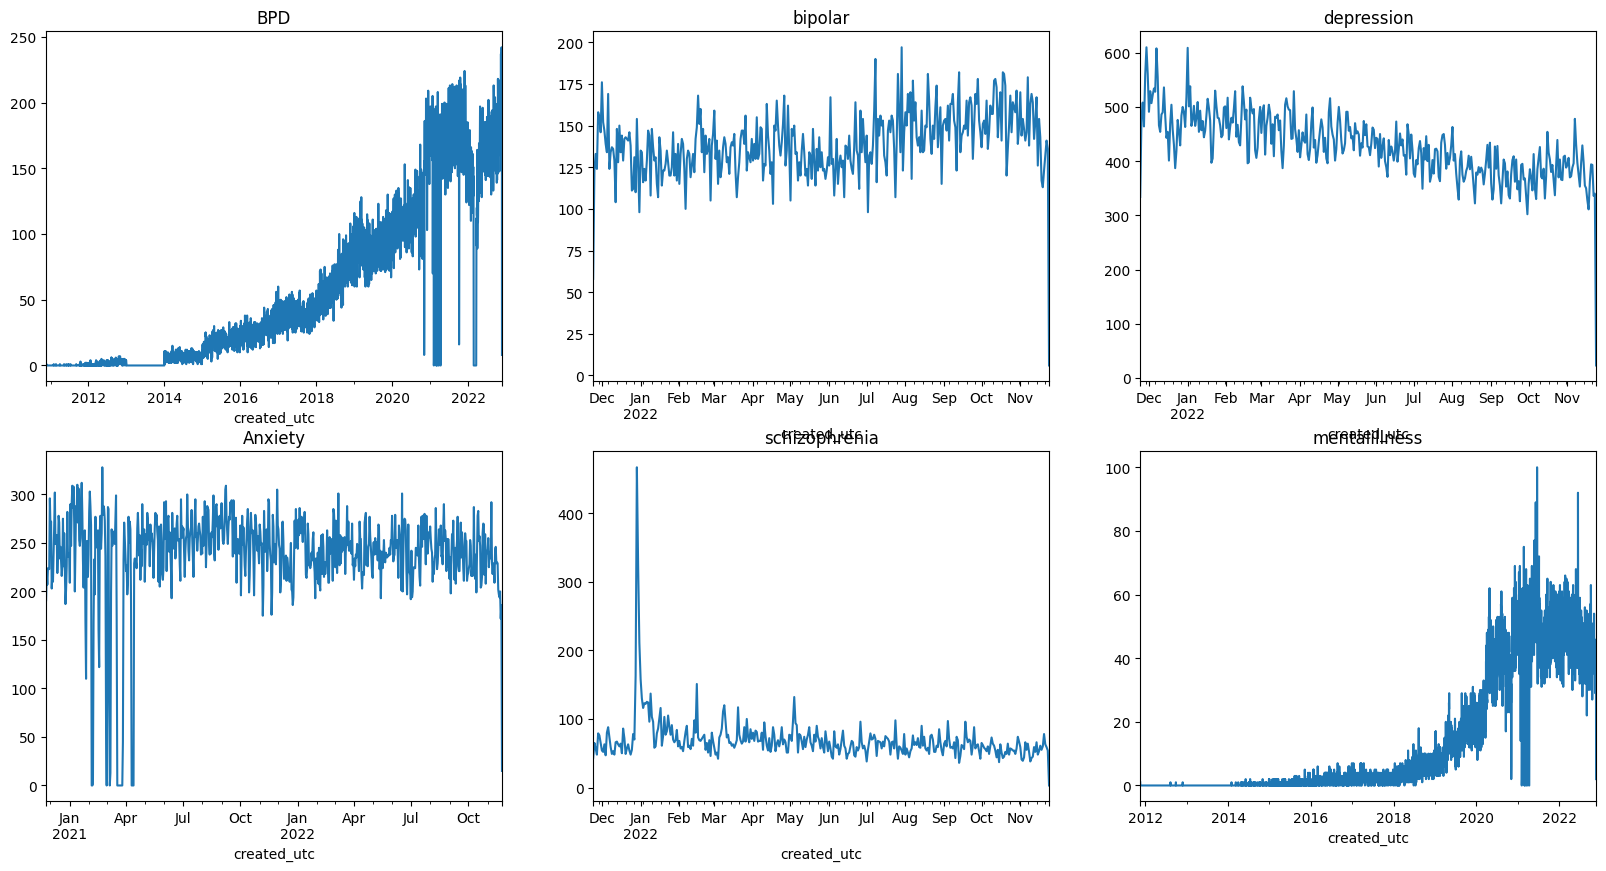

In [39]:
raw_data['created_utc'] = pd.to_datetime(raw_data['created_utc'], unit='s')

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, subreddit in enumerate(raw_data['subreddit'].unique()):
    raw_data[raw_data['subreddit'] == subreddit].resample('D', on='created_utc').size().plot(ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(subreddit)

Para reducir, voy a tomar el subreddit mas "joven" y tomar todos los posts de los demás subreddits a partir del primer post del sub más reciente, para no tener huecos vacíos en la línea temporal.

In [40]:
# get the first publication date for each subreddit and filter the data to get only the posts after that date for the whole dataset
first_pub_date = raw_data.groupby('subreddit')['created_utc'].min().max()

print('First publication date on the youngest subreddit:', first_pub_date)

First publication date on the youngest subreddit: 2021-11-24 11:01:28


In [41]:
filtered_data = raw_data[raw_data['created_utc'] >= first_pub_date]

print('Shape of the filtered data:', filtered_data.shape)

Shape of the filtered data: (392383, 5)


In [42]:
raw_data = filtered_data

La descripción del dataset indicaba que exsitían valores nulos y posts eliminados, por tanto, procedemos a eliminarlos, incluyendo los duplicados

In [43]:
raw_data.dropna(inplace=True)
removed_index = raw_data[raw_data['selftext'] == '[removed]'].index
raw_data.drop(removed_index, inplace=True)
duped_index = raw_data[raw_data.duplicated()].index
raw_data.drop(duped_index, inplace=True)

Eliminaré los saltos de línea

In [44]:
raw_data['title'] = raw_data['title'].str.replace('\n', ' ')
raw_data['selftext'] = raw_data['selftext'].str.replace('\n', ' ')

Finalmente crearé una columna con el texto procesado (eliminación de stopwords, lematización y tokenización, eliminación de emojis)

In [56]:

raw_data['processed_text'] = raw_data['title'] + ' ' + raw_data['selftext']
raw_data['processed_text'] = raw_data['processed_text'].apply(lambda x: emoji.replace_emoji(x, replace=''))
raw_data['processed_text'] = raw_data['processed_text'].str.replace('[^a-zA-Z\s]', '')
raw_data['processed_text'] = raw_data['processed_text'].str.lower()

raw_data['processed_text'].head()

0    life is so pointless without others does anyon...
1    cold rage? hello fellow friends   i'm on the b...
2    i don’t know who i am my [f20] bf [m20] told m...
3    help! opinions! advice! okay, i’m about to ope...
5    my ex got diagnosed with bpd without going int...
Name: processed_text, dtype: object

In [52]:
# remove stopwords and lemmatize the text, then join the tokens back together, use nltk for this

'''
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.stem(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

raw_data['processed_text'] = raw_data['processed_text'].apply(preprocess_text)

raw_data['processed_text'].head()
'''


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vramo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vramo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vramo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    life pointless without other anyon els think i...
1    cold rage ? hello fellow friend 'm bpd spectru...
2    ’ know [ f20 ] bf [ m20 ] told today ( said “ ...
3    help ! opinion ! advic ! okay , ’ open mani th...
5    ex got diagnos bpd without go detail , diagnos...
Name: processed_text, dtype: object

Ahora guardamos el nuevo dataframe, y vemos siguientes pasos

In [57]:
raw_data

,title,selftext,created_utc,over_18,subreddit,processed_text
0,Life is so pointless without others,Does anyone else think the most important part...,2022-04-19 08:29:20,False,BPD,life is so pointless without others does anyon...
1,Cold rage?,Hello fellow friends 😄 I'm on the BPD spectru...,2022-04-19 08:24:20,False,BPD,cold rage? hello fellow friends i'm on the b...
2,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,2022-04-19 08:02:59,False,BPD,i don’t know who i am my [f20] bf [m20] told m...
3,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",2022-04-19 07:30:30,False,BPD,"help! opinions! advice! okay, i’m about to ope..."
5,My ex got diagnosed with BPD,"Without going into detail, this diagnosis expl...",2022-04-19 06:43:55,False,BPD,my ex got diagnosed with bpd without going int...
...,...,...,...,...,...,...
666251,Is it safe to take 5-htp twice a week?,I took 50mg twice a day the past two days and ...,2021-11-24 13:54:22,False,mentalillness,is it safe to take 5-htp twice a week? i took ...
666252,Am I delusional?,Should I be hospitalized? Am I deluded or what...,2021-11-24 13:08:51,False,mentalillness,am i delusional? should i be hospitalized? am ...
666253,Idk what i have...,Somedays i feel fine. Somedays I just want to ...,2021-11-24 13:06:25,False,mentalillness,idk what i have... somedays i feel fine. somed...
666254,"HELP, I WANT TO KNOW IF MY GF IS LYING??",TW: sexual assault/ traumatic childhood expe...,2021-11-24 13:00:42,False,mentalillness,"help, i want to know if my gf is lying?? tw: s..."


In [58]:

raw_data['processed_text'].fillna('', inplace=True)

C:\Users\vramo\AppData\Local\Temp\ipykernel_27436\4052742835.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw_data['processed_text'].fillna('', inplace=True)


In [59]:
raw_data.to_csv('processed_data.csv', index=False)

## Procesamiento para análisis

Ahora realizaré los embeddings de los textos originales mediante un modelo de lenguaje.

In [2]:
df = pd.read_csv('processed_data.csv')

In [3]:
df.shape

(298309, 6)

In [4]:
model = SentenceTransformer('mixedbread-ai/mxbai-embed-large-v1', truncate_dim=512)

df['full_text'] = df['title'] + ' ' + df['selftext']
df['full_text'].fillna('', inplace=True)

texts = df['full_text'].values.tolist()

embeddings = model.encode(texts, show_progress_bar=True)

C:\Users\vramo\AppData\Local\Temp\ipykernel_25724\705797857.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['full_text'].fillna('', inplace=True)


Batches:   0%|          | 0/9323 [00:00<?, ?it/s]

c:\Users\vramo\miniconda3\envs\torch_env\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Además añadiré los resultados de un sentiment analysis por un modelo

In [4]:
cols = ['negative', 'neutral', 'positive']

In [11]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    return sentiment

sentiments = df['full_text'].apply(get_sentiment)

sentiments = pd.DataFrame(sentiments.tolist())




Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
c:\Users\vramo\miniconda3\envs\torch_env\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
C:\Users\vramo\AppData\Local\Temp\ipykernel_19572\3923951834.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the ope

## Análisis

In [6]:
df = pd.read_csv('processed_data.csv')
sentiments = pd.read_csv('sentiments.csv')

df = pd.concat([df, sentiments], axis=1)

In [7]:
df.head()

,title,selftext,created_utc,over_18,subreddit,processed_text,neg,neu,pos,compound
0,Life is so pointless without others,Does anyone else think the most important part...,2022-04-19 08:29:20,False,BPD,life is so pointless without others does anyon...,0.000,0.777,0.223,0.9564
1,Cold rage?,Hello fellow friends 😄 I'm on the BPD spectru...,2022-04-19 08:24:20,False,BPD,cold rage? hello fellow friends i'm on the b...,0.160,0.734,0.105,-0.9913
2,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,2022-04-19 08:02:59,False,BPD,i don’t know who i am my [f20] bf [m20] told m...,0.046,0.884,0.070,0.4137
3,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",2022-04-19 07:30:30,False,BPD,"help! opinions! advice! okay, i’m about to ope...",0.085,0.761,0.153,0.9972
4,My ex got diagnosed with BPD,"Without going into detail, this diagnosis expl...",2022-04-19 06:43:55,False,BPD,my ex got diagnosed with bpd without going int...,0.040,0.775,0.185,0.9896


Veamos la distribución de los posts por subreddit

<Axes: title={'center': 'Number of posts per subreddit since 2021-11-24 11:01:28'}, xlabel='subreddit'>

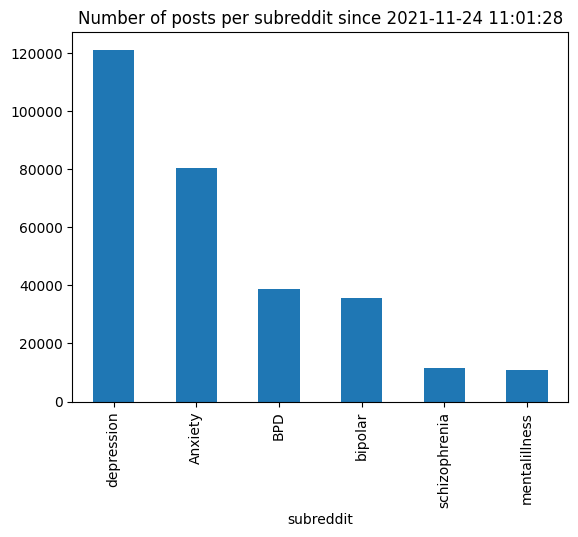

In [13]:
df.subreddit.value_counts().plot(kind='bar', title='Number of posts per subreddit since {}'.format(df['created_utc'].min()))

La distribución refleja la realidad de que la depresión y la ansiendad son de las enfermedades mentales más comunes en la actualidad, y por tanto, los subreddits más populares. A continuación, veremos la distribución de los posts por año
y veremos la distribución de los sentiminientos en los posts de los distintos subs.

Means:
                    neg       neu       pos  compound
subreddit                                            
Anxiety        0.150430  0.747716  0.101853 -0.298019
BPD            0.131746  0.750189  0.118069 -0.131368
bipolar        0.113339  0.780767  0.105895 -0.071909
depression     0.164051  0.719515  0.116433 -0.318932
mentalillness  0.139491  0.757109  0.103387 -0.295022
schizophrenia  0.096912  0.799795  0.103294  0.010531

Medians:
                 neg    neu    pos  compound
subreddit                                   
Anxiety        0.143  0.752  0.095   -0.6727
BPD            0.127  0.751  0.113   -0.4832
bipolar        0.106  0.783  0.098   -0.1612
depression     0.155  0.724  0.110   -0.7264
mentalillness  0.135  0.759  0.097   -0.7003
schizophrenia  0.087  0.801  0.092    0.0000


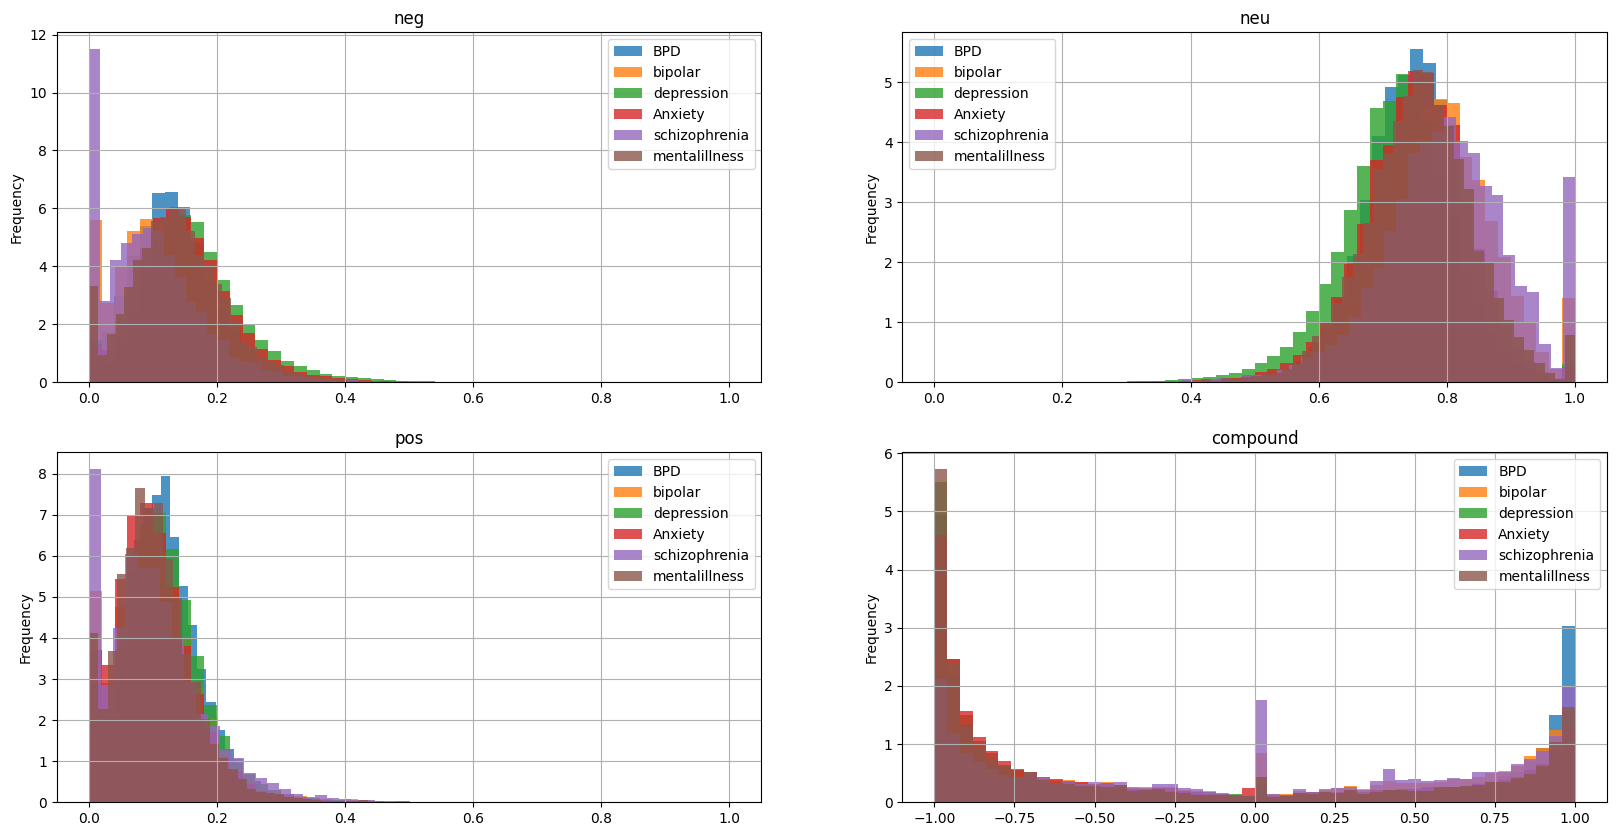

In [24]:
# for each sentiment, plot the histogram of the number of posts per subreddit
sentiments = ['neg', 'neu', 'pos', 'compound']
subreddits = df['subreddit'].unique()

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

for i, sentiment in enumerate(sentiments):

    for j, subreddit in enumerate(subreddits):
        df[df['subreddit'] == subreddit][sentiment].plot(kind='hist', ax=ax[i // 2, i % 2], alpha=0.8, label=subreddit, density=True, bins = 50)
        ax[i // 2, i % 2].set_title(sentiment)
        ax[i // 2, i % 2].legend()
        ax[i // 2, i % 2].grid(True)


# title of the whole plot
plt.suptitle('Sentiment distribution per subreddit', fontsize=16)

# print the mean for each sentiment per subreddit
means = df.groupby('subreddit')[sentiments].mean()
medians = df.groupby('subreddit')[sentiments].median()
print('Means:')
print(means)
print()
print('Medians:')
print(medians)

Las distribuciones son similares, schizophrenia parece ser el más polarizado.

Compound es una de los valores que se obtienen en el análisis de sentimientos, y es una combinación de los valores de negatividad, positividad y neutralidad, basandose en el análisis de las palabras del texto. Veamos la distribución de los valores de compound en los distintos subreddits y si se pueden discernir diferencias entre ellos.

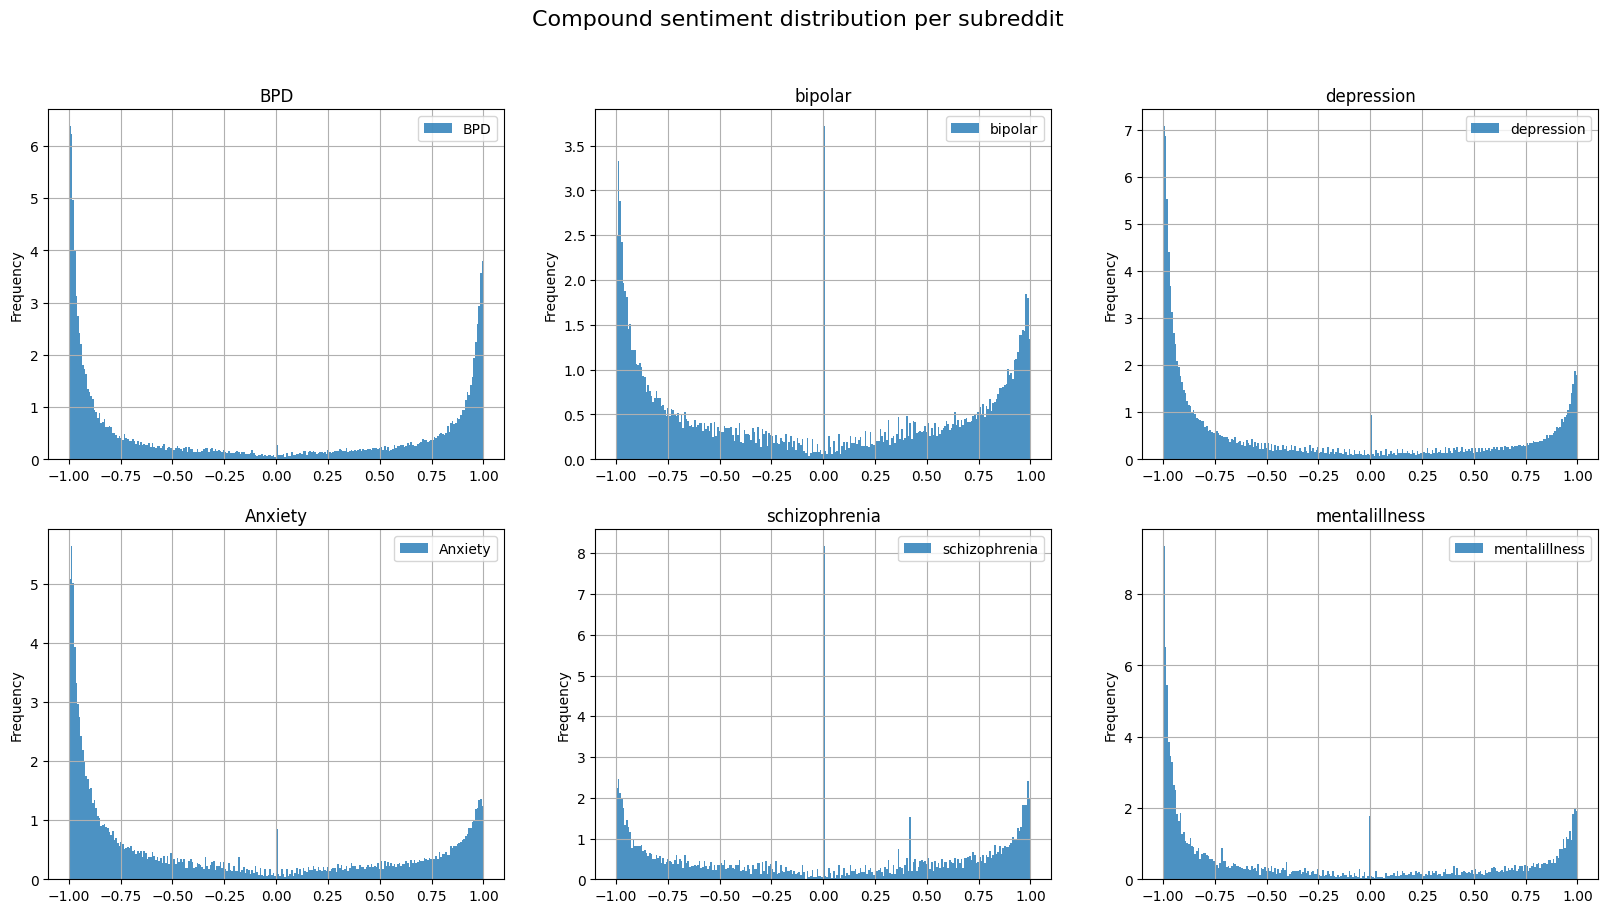

In [27]:
# plot histograms of compund sentiment for each subreddit
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

plt.suptitle('Compound sentiment distribution per subreddit', fontsize=16)

for i, subreddit in enumerate(df['subreddit'].unique()):
    df[df['subreddit'] == subreddit]['compound'].plot(kind='hist', ax=ax[i // 3, i % 3], alpha=0.8, label=subreddit, density=True, bins=250)
    ax[i // 3, i % 3].set_title(subreddit)
    ax[i // 3, i % 3].legend()
    ax[i // 3, i % 3].grid(True)



    

- **BPD (Borderline Personality Disorder)**:

    La distribución tiene forma de "U", con muchos comentarios polarizados, tanto en los extremos negativos (-1.00) como positivos (1.00). Los comentarios neutros (cercanos a 0) son menos frecuentes.


- **Bipolar**:

    También muestra una distribución en forma de "U", aunque con un pico significativo alrededor de 0. Esto sugiere que los comentarios en este subreddit son más polarizados, pero con una tendencia leve hacia la neutralidad.


- **Depression**:

    Este subreddit tiene una fuerte inclinación hacia los sentimientos negativos, con un pico considerable alrededor de -1.00. Aunque hay una pequeña cantidad de comentarios positivos, predominan los comentarios negativos.


- **Anxiety**:

    Al igual que los otros subreddits, muestra una distribución en forma de "U", con una alta frecuencia de comentarios en los extremos negativos y positivos. Sin embargo, los comentarios cercanos al 0 son más frecuentes que en algunos de los otros subreddits.


- **Schizophrenia**:

    Tiene una distribución bastante polarizada, con picos significativos tanto en el extremo negativo como positivo. Parece que las emociones expresadas en este subreddit son altamente intensas.


- **Mentalillness**:

    Este subreddit muestra una fuerte polarización con picos en ambos extremos, pero los comentarios negativos parecen ser más predominantes.

Seguidamente, los posts también contienen una marca de si es contenido +18, puede ser interesante ver si hay diferencias en los sentimientos de los posts en función de si son +18 o no. Y dados los embeddings, ¿podemos crear un modelo de clasificación para predecir si un post es +18 o no?

In [42]:
# plot the correlation between sentiment and over_18

df[['neg', 'neu', 'pos', 'compound', 'over_18']].corr()



,neg,neu,pos,compound,over_18
neg,1.000000,-0.710035,-0.240502,-0.626338,0.041584
neu,-0.710035,1.000000,-0.512714,0.116397,-0.028308
pos,-0.240502,-0.512714,1.000000,0.603206,-0.011672
compound,-0.626338,0.116397,0.603206,1.000000,-0.048369
over_18,0.041584,-0.028308,-0.011672,-0.048369,1.000000


Respecto a sentimientos, no parecen afectar enormemente a la correlación, por tanto no existe una relación clara entre los sentimientos y la edad de los posts. 